# Comparison of Multivariate vs. Bivariate Approach to Connectivity Estimation
**SYNCCIN 2025 Summer School**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jzygierewicz/SYNCCIN_2025_summer_school/blob/main/3_channels_MVAR.ipynb)

---

This notebook demonstrates advanced connectivity analysis using Multivariate Autoregressive (MVAR) modeling and Directed Transfer Function (DTF) for EEG data analysis. The comparison includes:

- **Bivariate vs. Multivariate MVAR modeling**
- **Spectral analysis and cross-spectral estimation**  
- **Directed Transfer Function (DTF) computation**
- **Interactive visualizations of connectivity patterns**
- **Network graph representations**

**Key Learning Objectives:**
1. Understand the differences between bivariate and multivariate approaches
2. Learn MVAR model order selection using information criteria
3. Compute and interpret DTF for connectivity analysis
4. Visualize connectivity patterns using interactive plots and network graphs
---

## Setup and Installation

First, let's install the required packages for Google Colab:

In [4]:
# Install required packages for Google Colab
!pip install networkx joblib xmltodict neurokit2
#!pip install plotly networkx scipy joblib ipywidgets

# Enable plotly for Colab
# import plotly.io as pio
# pio.renderers.default = "colab"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 19.3 MB/s eta 0:00:00


## Import Required Libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
import networkx as nx
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots
# import plotly.figure_factory as ff

# Note: Custom modules (mtmvar and utils) will be imported after downloading
# Run the download section first to get these modules from the GitHub repository

## Download Required Files

Let's download all the required files directly from the GitHub repository:
- Data files (`.joblib` format)
- Python modules (`mtmvar.py` and `utils.py`)

In [6]:
import urllib.request
import os

# GitHub repository information
github_user = "jzygierewicz"
repo_name = "SYNCCIN_2025_summer_school"
branch = "main"

# Files to download
files_to_download = [
    "simulated_3_channels.joblib",
    "mtmvar.py",
    "utils.py"
]

print("Downloading required files from GitHub repository...")

for filename in files_to_download:
    url = f"https://raw.githubusercontent.com/{github_user}/{repo_name}/{branch}/{filename}"

    try:
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)

        # Check if file was downloaded successfully
        if os.path.exists(filename):
            file_size = os.path.getsize(filename)
            print(f" {filename} downloaded successfully ({file_size:,} bytes)")
        else:
            print(f" Failed to download {filename}")

    except Exception as e:
        print(f" Error downloading {filename}: {str(e)}")
        print(f"  You may need to upload this file manually to your Colab session")

print("\nDownload process completed!")
print("\nAvailable files in current directory:")
for f in os.listdir("."):
    if f.endswith((".joblib", ".pkl", ".py")):
        size = os.path.getsize(f)
        print(f"  - {f} ({size:,} bytes)")

# Verify Python modules can be imported
print("\nTesting Python module imports...")
try:
    from mtmvar import mvar_criterion, AR_coeff, mvar_H, mvar_plot
    print(" mtmvar module imported successfully")
except ImportError as e:
    print(f" Error importing mtmvar: {e}")

try:
    from utils import describe_dict
    print(" utils module imported successfully")
except ImportError as e:
    print(f" Error importing utils: {e}")

print("\nSetup completed! You can now run the analysis.")

 simulated_3_channels.joblib downloaded successfully (48,392 bytes)
 mtmvar.py downloaded successfully (20,086 bytes)
 utils.py downloaded successfully (32,758 bytes)

Download process completed!

Available files in current directory:
  - utils.py (32,758 bytes)
  - mtmvar.py (20,086 bytes)
  - simulated_3_channels.joblib (48,392 bytes)

Testing Python module imports...
 mtmvar module imported successfully
 utils module imported successfully

Setup completed! You can now run the analysis.


## Import Custom Modules

Now that we've downloaded the custom modules, let's import the required functions:

In [7]:
# Import custom modules that were downloaded from the repository
try:
    from mtmvar import mvar_criterion, AR_coeff, mvar_H, mvar_plot, graph_plot
    print(" Successfully imported mtmvar functions.")
except ImportError as e:
    print(f" Error importing mtmvar module: {e}")
    print("Make sure you ran the download section first!")

try:
    from utils import describe_dict
    print(" Successfully imported utils functions.")
except ImportError as e:
    print(f" Error importing utils module: {e}")
    print("Make sure you ran the download section first!")

print("\nAll modules ready for MVAR connectivity analysis!")

 Successfully imported mtmvar functions.
 Successfully imported utils functions.

All modules ready for MVAR connectivity analysis!


## Load and Explore Data

Let's load the simulated 3-channel EEG data and explore its characteristics:

In [8]:
# Load simulation data from simulated_3_channels.joblib
# This file was downloaded automatically from the GitHub repository
data = joblib.load('simulated_3_channels.joblib')
describe_dict(data)

sim1 = data['EEG']
Fs = data['Fs'].item()
N_chan, N_samp = sim1.shape
sim_chan_names = ['0', '1', '2']
print(f"\n=== DATA CHARACTERISTICS ===")
print(f"Number of channels: {N_chan}")
print(f"Number of samples: {N_samp}")
print(f"Sampling frequency: {Fs} Hz")
print(f"Data duration: {N_samp/Fs:.2f} seconds")
print(f"Data shape: {sim1.shape}")

EEG: ndarray, shape=(3, 2000), dtype=float64
Fs: ndarray, shape=(1, 1), dtype=uint8
channels: dict, keys=['O1', 'O1_1dt', 'O1_2dt']

=== DATA CHARACTERISTICS ===
Number of channels: 3
Number of samples: 2000
Sampling frequency: 128 Hz
Data duration: 15.62 seconds
Data shape: (3, 2000)


## Visualize the EEG Signals

Let's plot the 3-channel EEG signals using interactive Plotly visualizations:

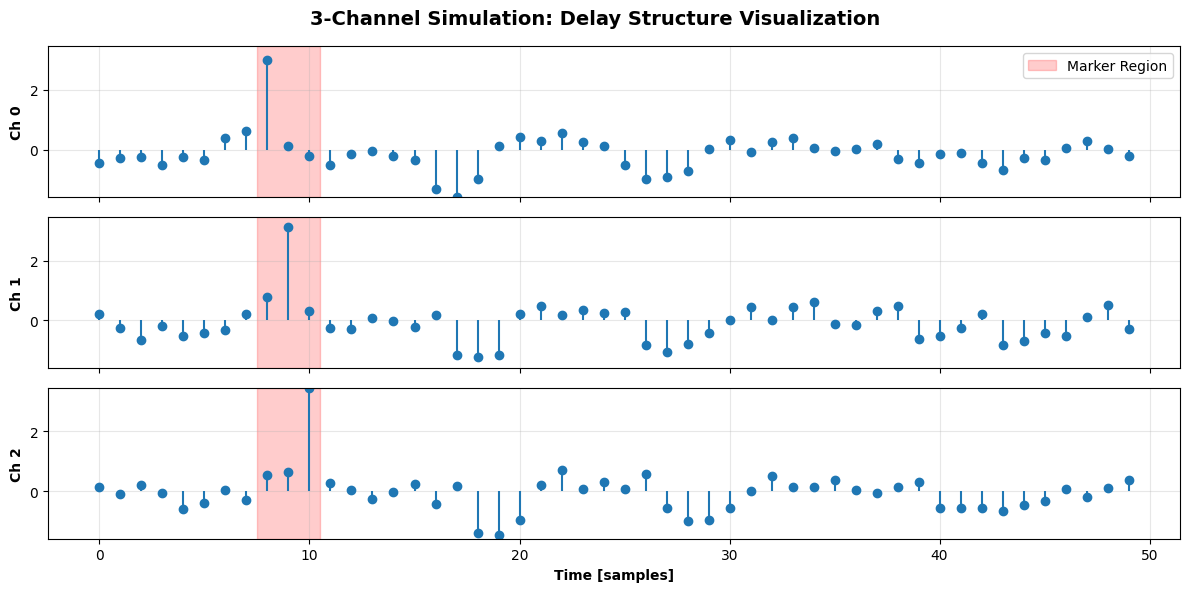

Observe the marker (red region) progression across channels
Notice how the marker appears later in higher-numbered channels
This demonstrates the simulated connectivity structure


In [9]:
# Visualize the first 50 samples to see the delay structure
idx = np.arange(0, 50, 1)
Min = np.min(sim1[:, idx])
Max = np.max(sim1[:, idx])

# Create figure with N_chan subplots
fig, ax = plt.subplots(N_chan, 1, sharex=True, figsize=(12, 6))
fig.suptitle('3-Channel Simulation: Delay Structure Visualization', fontsize=14, fontweight='bold')

for i in range(N_chan):
    ax[i].stem(idx, sim1[i, idx], basefmt=" ")
    ax[i].set_ylabel(f'Ch {i}', fontweight='bold')
    ax[i].set_ylim([Min, Max])
    ax[i].grid(True, alpha=0.3)

    # Highlight the marker region
    ax[i].axvspan(7.5, 10.5, alpha=0.2, color='red', label='Marker Region')

ax[N_chan-1].set_xlabel('Time [samples]', fontweight='bold')
ax[0].legend()
plt.tight_layout()
plt.show()

print("Observe the marker (red region) progression across channels")
print("Notice how the marker appears later in higher-numbered channels")
print("This demonstrates the simulated connectivity structure")


# MVAR Model Theory reminder

**Multivariate Autoregressive (MVAR) Model**

The MVAR model describes the relationship between channels in a multivariate time series:

$$\mathbf{x}(t) = \sum_{k=1}^{p} \mathbf{A}_k \mathbf{x}(t-k) + \mathbf{e}(t)$$

Where:
- $\mathbf{x}(t)$ is the multichannel signal vector at time $t$
- $\mathbf{A}_k$ are the autoregressive coefficient matrices
- $p$ is the model order
- $\mathbf{e}(t)$ is the noise vector

**Model Order Selection**

We use information criterion **AIC** to determine the optimal model order $p$.

**Directed Transfer Function (DTF)**

DTF quantifies the directional flow of information between channels:

$$DTF_{ij}(f) = |H_{ij}(f)|^2$$

Where $H_{ij}(f)$ is the transfer function from channel $j$ to channel $i$.

# Model Estimation

We will model the signal using a multivariate autoregressive (MVAR) model and compare bivariate vs. multivariate approaches.

Let's set up the analysis parameters:

In [14]:
max_p = 15          # Maximum model order to test
crit_type = 'AIC'   # Information criterion (AIC or BIC)
f = np.arange(0, 30, 0.1)  # Frequency range for analysis
N_f = f.shape[0]    # Number of frequency points

# SPECTRAL ANALYSIS

First, let us examine the estimation of spectra and cross-spectra using the bivariate and multivariate approaches.

## Bivariate Approach

In the bivariate approach, we estimate the model order separately for each pair of channels. This means we analyze each channel pair independently.

In [15]:
# Initialize the bivariate spectrum
S_bivariate = np.zeros((N_chan, N_chan, N_f), dtype=np.complex128) #note: complex128 for complex numbers

# Process each channel pair
for ch1 in range(N_chan):
    for ch2 in range(ch1+1, N_chan):
        print(f"\nProcessing channel pair: {ch1} ↔ {ch2}")

        # Create bivariate signal
        x = np.vstack((sim1[ch1, :], sim1[ch2, :]))

        # Estimate optimal model order for this pair
        crit, p_range, p_opt = mvar_criterion(x, max_p, crit_type, False)
        print(f"  Optimal model order: p = {p_opt}")

        # Estimate AR coefficients and compute transfer function
        Ar, V = AR_coeff(x, p_opt)
        H, _ = mvar_H(Ar, f, Fs)

        # Compute spectrum for this channel pair
        S_2chan = np.zeros((2, 2, N_f), dtype=np.complex128)
        for fi in range(N_f):
            S_2chan[:, :, fi] = H[:, :, fi].dot(V.dot(H[:, :, fi].T))

        # Store results in the global bivariate spectrum matrix
        S_bivariate[ch1, ch1, :] = S_2chan[0, 0, :]
        S_bivariate[ch2, ch2, :] = S_2chan[1, 1, :]
        S_bivariate[ch1, ch2, :] = S_2chan[0, 1, :]
        S_bivariate[ch2, ch1, :] = S_2chan[1, 0, :]

print("\n Bivariate spectral analysis completed!")


Processing channel pair: 0 ↔ 1
  Optimal model order: p = 15

Processing channel pair: 0 ↔ 2
  Optimal model order: p = 14

Processing channel pair: 1 ↔ 2
  Optimal model order: p = 15

 Bivariate spectral analysis completed!


## Multivariate Approach

In the multivariate approach, we estimate the model order for all channels simultaneously. This provides a more comprehensive view of the system dynamics.

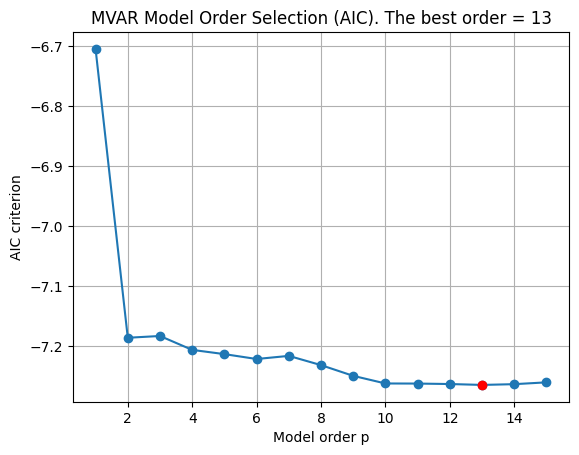

Optimal model order for all channels: p = 13
 Multivariate spectral analysis completed!

=== MODEL ORDER COMPARISON ===
Note: The multivariate approach typically results in lower model orders


In [16]:
x = sim1

# Estimate optimal model order for all channels
crit, p_range, p_opt = mvar_criterion(x, max_p, crit_type, True)
print(f"Optimal model order for all channels: p = {p_opt}")

# Estimate AR coefficients and compute transfer function
Ar, V = AR_coeff(x, p_opt)
H, _ = mvar_H(Ar, f, Fs)

# Compute multivariate spectrum
S_multivariate = np.zeros((N_chan, N_chan, N_f), dtype=np.complex128)
for fi in range(N_f):
    S_multivariate[:, :, fi] = H[:, :, fi].dot(V.dot(H[:, :, fi].T))

print(" Multivariate spectral analysis completed!")

# Display model order comparison
print(f"\n=== MODEL ORDER COMPARISON ===")
print("Note: The multivariate approach typically results in lower model orders")


## Spectral Visualization

Let's create  plots to compare the bivariate and multivariate spectral estimates:

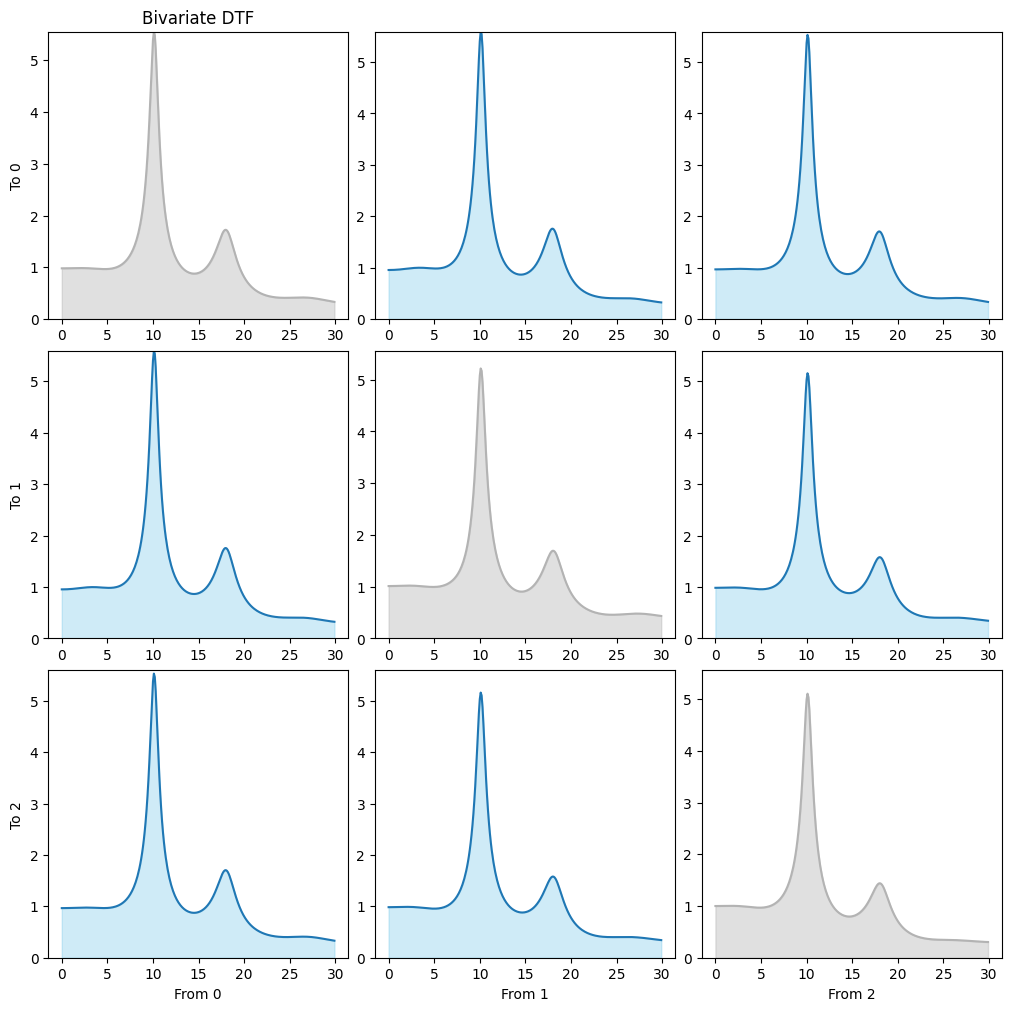

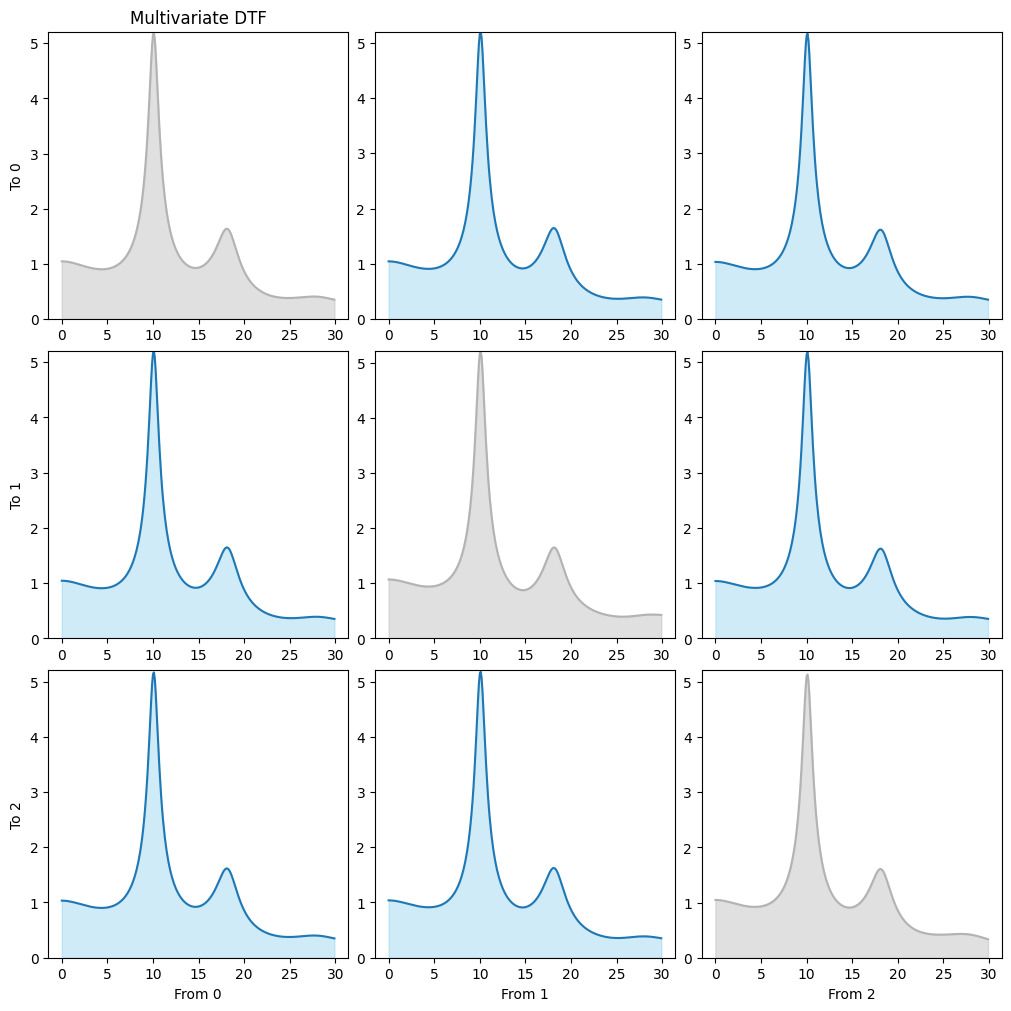

In [17]:
mvar_plot(S_bivariate, S_bivariate,   f, 'From ', 'To ',  sim_chan_names, 'Bivariate DTF' ,'sqrt')
mvar_plot(S_multivariate, S_multivariate,   f, 'From ', 'To ', sim_chan_names, 'Multivariate DTF' ,'sqrt')
plt.show()

## Spectral Analysis Results

**Key Observations:**

1. **Diagonal Elements (Auto-spectra)**: Show the power spectral density of each individual channel
2. **Off-diagonal Elements (Cross-spectra)**: Reveal the spectral similarities between channel pairs
3. **Alpha Peak**: Look for the characteristic alpha rhythm peak around 8-12 Hz
4. **Approach Differences**: Compare the spectral profiles between bivariate and multivariate methods

**Expected Differences:**
- Bivariate approach may show **narrower spectral peaks** due to higher model orders

# DIRECTED TRANSFER FUNCTION (DTF) ANALYSIS

Now let's compute the Directed Transfer Function to analyze directional connectivity patterns.

**Bivariate DTF Computation**

In [18]:
# Initialize the bivariate DTF
DTF_bivariate = np.zeros((N_chan, N_chan, N_f), dtype=np.complex128) # note: complex128 for complex numbers

# Process each channel pair for DTF
for ch1 in range(N_chan):
    for ch2 in range(ch1+1, N_chan):
        print(f"Computing DTF for channel pair: {ch1} ↔ {ch2}")

        # Create bivariate signal
        x = np.vstack((sim1[ch1, :], sim1[ch2, :]))

        # Estimate model parameters
        _, _, p_opt = mvar_criterion(x, max_p, crit_type, False)
        Ar, _ = AR_coeff(x, p_opt)
        H, _ = mvar_H(Ar, f, Fs)

        # Compute DTF (squared magnitude of transfer function)
        DTF_2chan = np.abs(H)**2

        # Store in the global DTF matrix
        DTF_bivariate[ch1, ch2, :] = DTF_2chan[0, 1, :]  # ch1 → ch2
        DTF_bivariate[ch2, ch1, :] = DTF_2chan[1, 0, :]  # ch2 → ch1

print(" Bivariate DTF computation completed!")

Computing DTF for channel pair: 0 ↔ 1
Computing DTF for channel pair: 0 ↔ 2
Computing DTF for channel pair: 1 ↔ 2
 Bivariate DTF computation completed!


**Multivariate DTF Computation**

In [19]:
# Estimate model parameters for all channels
_, _, p_opt = mvar_criterion(sim1, max_p, crit_type, False)
print(f"Using model order: p = {p_opt}")

Ar, _ = AR_coeff(sim1, p_opt)
H, _ = mvar_H(Ar, f, Fs)

# Compute multivariate DTF
DTF_multivariate = np.abs(H)**2

print(" Multivariate DTF computation completed!")

Using model order: p = 13
 Multivariate DTF computation completed!


## DTF Visualization

Let's create visualizations of the DTF results:

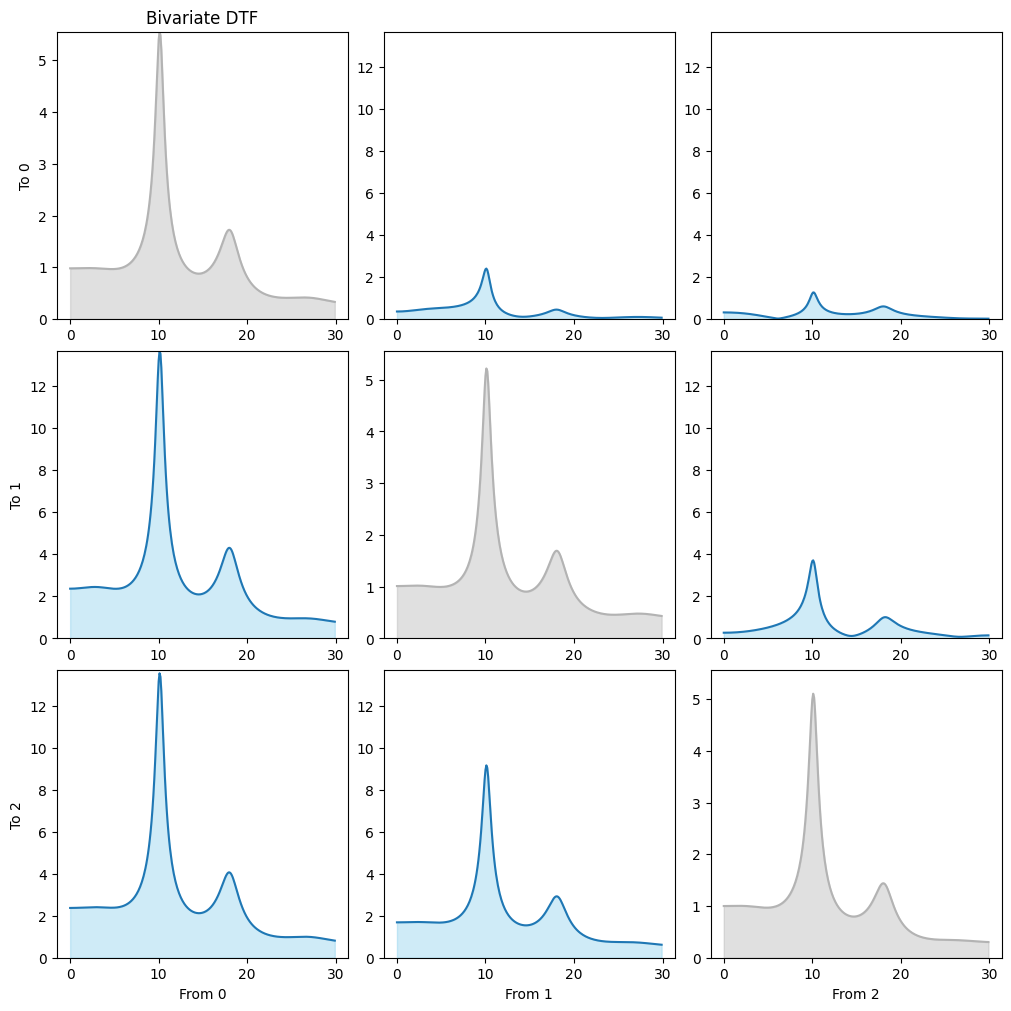

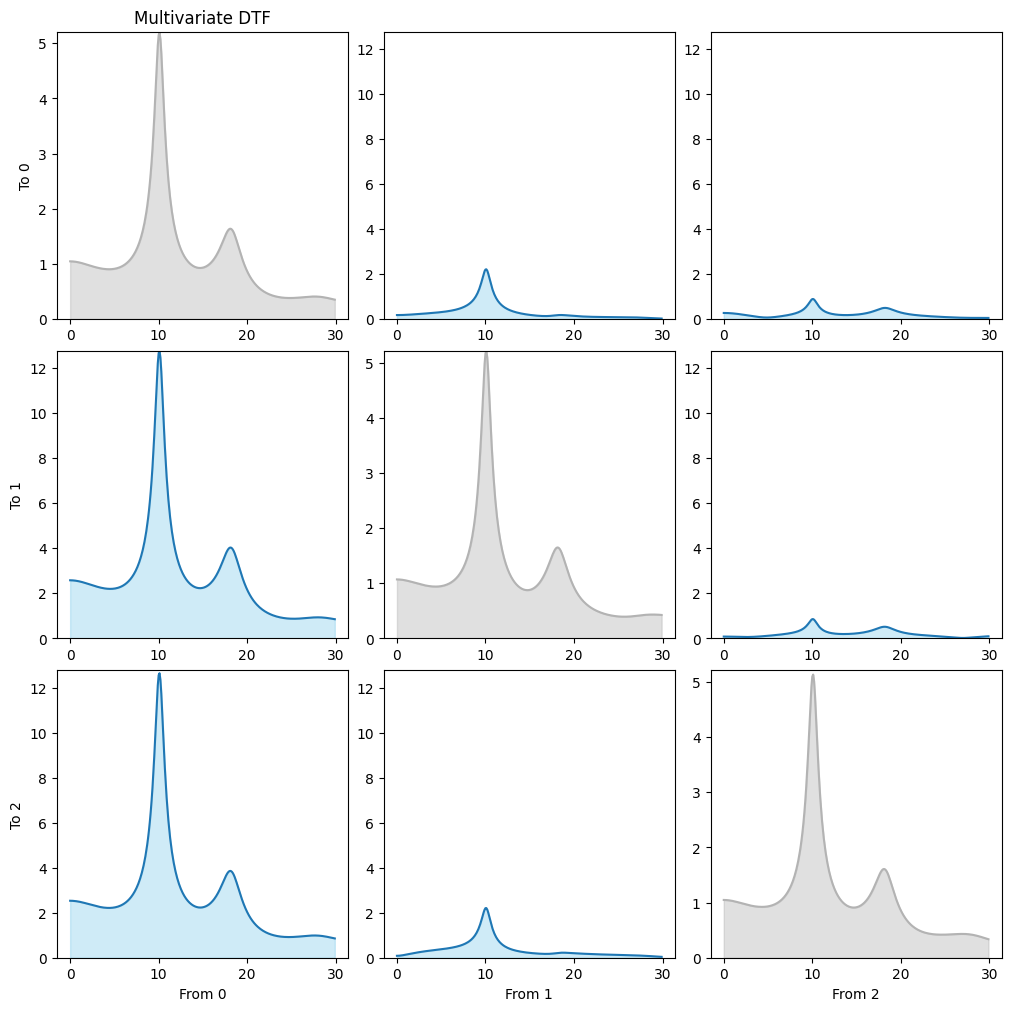

In [20]:
mvar_plot(S_bivariate, DTF_bivariate,   f, 'From ', 'To ',  sim_chan_names, 'Bivariate DTF' ,'sqrt')
mvar_plot(S_multivariate, DTF_multivariate,   f, 'From ', 'To ', sim_chan_names, 'Multivariate DTF' ,'sqrt')
plt.show()

## Network Visualization

Create the network plots:

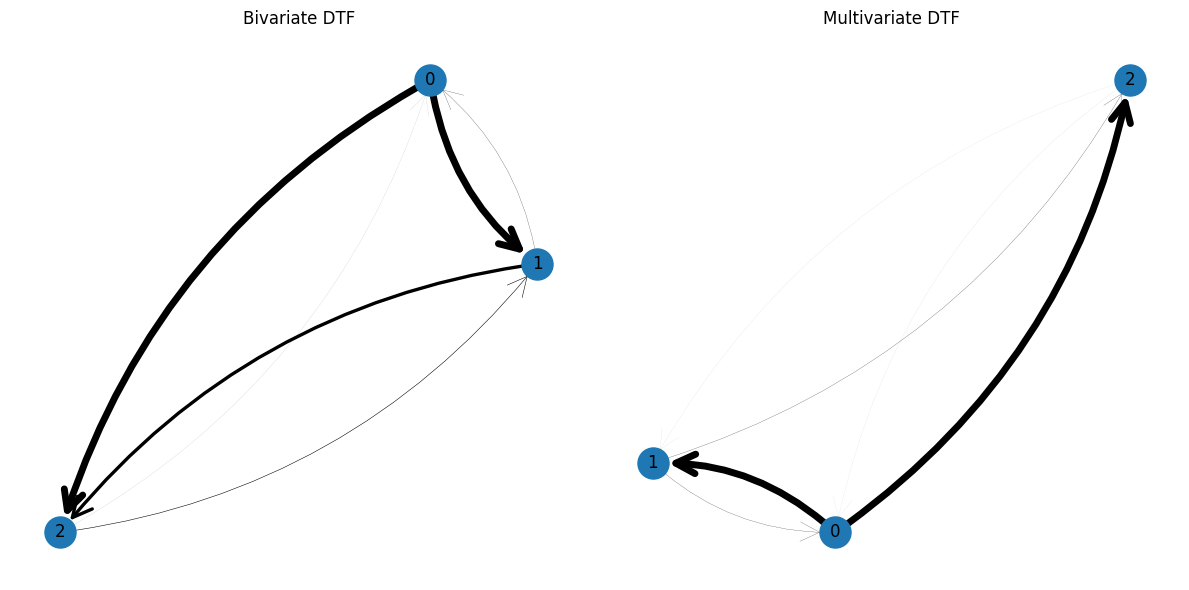

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
f_range = (8, 12)  # frequency range for alpha band
G_bivariate = graph_plot(DTF_bivariate, axs[0], f, f_range, sim_chan_names, 'Bivariate DTF')
G_multivariate = graph_plot(DTF_multivariate, axs[1], f, f_range, sim_chan_names, 'Multivariate DTF')
plt.tight_layout()
plt.show()

# Key Findings and Interpretation

**Spectral Analysis Comparison**
- Botch approaches yield very similar results in spectral and cross-spectral analysis
- **Bivariate approach**: usually estimates higher model orders and potentially narrower spectral peaks


**DTF Connectivity Analysis**
- **Bivariate DTF**: May show spurious connections due to indirect pathways
- **Multivariate DTF**: Better at revealing true direct connections
- **Frequency-specific analysis** reveals rhtyhms engaged in the connectivity

**Network Topology**
- **Edge thickness**: Proportional to connection strength
- **Network density**: Compare the number and strength of connections

**Practical recommendations:**
- **Use multivariate approach** when possible for more accurate connectivity estimates
- **Bivariate approach** may be necessary for very high-dimensional data due to computational constraints
- **Model order selection** is important for both approaches


### Further Reading and Advanced Topics

**Extended Analysis Methods:**
- **Partial Directed Coherence (PDC)**: Alternative to DTF with different normalization
- **Time-varying connectivity**: Analysis of dynamic changes in connectivity
- **Statistical significance testing**: Surrogate data methods for connectivity validation

**Technical Considerations:**
- **Stationarity requirements**: MVAR models assume stationary signals
- **Model order selection**: Different criteria (AIC, SC, HQ) may give different results, but if overfitting is observed (spurious splitting of spectral peaks) manual setting may be required
- **Frequency resolution**: Trade-off between frequency and time resolution
- **Multiple comparison correction**: Important when analyzing many connections


---

**Educational Materials**: [SYNCCIN 2025 Repository](https://github.com/jzygierewicz/SYNCCIN_2025_summer_school)
- **Author**: Jarosław Żygierewicz
- **Institution**: University of Warsaw
- **Event**: SYNCCIN 2025 Summer School

```markdown
# Comparison of Multivariate vs. Bivariate Approach to Connectivity Estimation
**SYNCCIN 2025 Summer School**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jzygierewicz/SYNCCIN_2025_summer_school/blob/main/3_channels_MVAR.ipynb)

* * *

This notebook demonstrates advanced connectivity analysis using Multivariate Autoregressive (MVAR) modeling and Directed Transfer Function (DTF) for EEG data analysis. The comparison includes:

- **Bivariate vs. Multivariate MVAR modeling**
- **Spectral analysis and cross-spectral estimation**  
- **Directed Transfer Function (DTF) computation**
- **Interactive visualizations of connectivity patterns**
- **Network graph representations**

**Key Learning Objectives:**
1. Understand the differences between bivariate and multivariate approaches
2. Learn MVAR model order selection using information criteria
3. Compute and interpret DTF for connectivity analysis
4. Visualize connectivity patterns using interactive plots and network graphs
* * *


```markdown
## Setup and Installation

First, let's install the required packages for Google Colab:
```

```markdown
## Import Required Libraries
```

```markdown
## Download Required Files

Let's download all the required files directly from the GitHub repository:
- Data files (`.joblib` format)
- Python modules (`mtmvar.py` and `utils.py`)
```

```markdown
## Import Custom Modules

Now that we've downloaded the custom modules, let's import the required functions:
```

```markdown
## Load and Explore Data

Let's load the simulated 3-channel EEG data and explore its characteristics:
```

```markdown
## Visualize the EEG Signals

Let's plot the 3-channel EEG signals using interactive Plotly visualizations:
```

```markdown
# MVAR Model Theory reminder

**Multivariate Autoregressive (MVAR) Model**

The MVAR model describes the relationship between channels in a multivariate time series:

$$\mathbf{x}(t) = \sum_{k=1}^{p} \mathbf{A}_k \mathbf{x}(t-k) + \mathbf{e}(t)$$

Where:
- $\mathbf{x}(t)$ is the multichannel signal vector at time $t$
- $\mathbf{A}_k$ are the autoregressive coefficient matrices
- $p$ is the model order
- $\mathbf{e}(t)$ is the noise vector

**Model Order Selection**

We use the information criterion **AIC** to determine the optimal model order $p$.

**Directed Transfer Function (DTF)**

DTF quantifies the directional flow of information between channels:

$$DTF_{ij}(f) = |H_{ij}(f)|^2$$

Where $H_{ij}(f)$ is the transfer function from channel $j$ to channel $i$.
```

```markdown
# Model Estimation

We will model the signal using a multivariate autoregressive (MVAR) model and compare bivariate vs. multivariate approaches.

Let's set up the analysis parameters:
```

```markdown
# SPECTRAL ANALYSIS

First, let us examine the estimation of spectra and cross-spectra using the bivariate and multivariate approaches.

## Bivariate Approach

In the bivariate approach, we estimate the model order separately for each pair of channels. This means we analyze each channel pair independently.
```

```markdown
## Multivariate Approach

In the multivariate approach, we estimate the model order for all channels simultaneously. This provides a more comprehensive view of the system dynamics.
```

```markdown
## Spectral Visualization

Let's create plots to compare the bivariate and multivariate spectral estimates:
```

```markdown
## Spectral Analysis Results

**Key Observations:**

1. **Diagonal Elements (Auto-spectra)**: Show the power spectral density of each individual channel
2. **Off-diagonal Elements (Cross-spectra)**: Reveal the spectral similarities between channel pairs
3. **Alpha Peak**: Look for the characteristic alpha rhythm peak around 8-12 Hz
4. **Approach Differences**: Compare the spectral profiles between bivariate and multivariate methods

**Expected Differences:**
- Bivariate approach may show **narrower spectral peaks** due to higher model orders
```

```markdown
# DIRECTED TRANSFER FUNCTION (DTF) ANALYSIS

Now let's compute the Directed Transfer Function to analyze directional connectivity patterns.

**Bivariate DTF Computation**
```

```markdown
**Multivariate DTF Computation**
```

```markdown
## DTF Visualization

Let's create visualizations of the DTF results:
```

```markdown
## Network Visualization

Create the network plots:
```

```markdown
# Key Findings and Interpretation

**Spectral Analysis Comparison**
- Both approaches yield very similar results in spectral and cross-spectral analysis
- **Bivariate approach**: usually estimates higher model orders and potentially narrower spectral peaks

**DTF Connectivity Analysis**
- **Bivariate DTF**: May show spurious connections due to indirect pathways
- **Multivariate DTF**: Better at revealing true direct connections
- **Frequency-specific analysis** reveals rhythms engaged in the connectivity

**Network Topology**
- **Edge thickness**: Proportional to connection strength
- **Network density**: Compare the number and strength of connections

**Practical recommendations:**
- **Use the multivariate approach** when possible for more accurate connectivity estimates
- **Bivariate approach** may be necessary for very high-dimensional data due to computational constraints
- **Model order selection** is important for both approaches

```

```markdown
### Further Reading and Advanced Topics

**Extended Analysis Methods:**
- **Partial Directed Coherence (PDC)**: Alternative to DTF with different normalization
- **Time-varying connectivity**: Analysis of dynamic changes in connectivity
- **Statistical significance testing**: Surrogate data methods for connectivity validation

**Technical Considerations:**
- **Stationarity requirements**: MVAR models assume stationary signals
- **Model order selection**: Different criteria (AIC, SC, HQ) may give different results, but if overfitting is observed (spurious splitting of spectral peaks) manual setting may be required
- **Frequency resolution**: Trade-off between frequency and time resolution
- **Multiple comparison correction**: Important when analyzing many connections

* * *
```

```markdown
**Educational Materials**: [SYNCCIN 2025 Repository](https://github.com/jzygierewicz/SYNCCIN_2025_summer_school)
- **Author**: Jarosław Żygierewicz
- **Institution**: University of Warsaw
- **Event**: SYNCCIN 2025 Summer School
```